In [1]:
# box cox transform
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

The data, descriptions of the variables and some examples can be found here:
[house-pricese-from-kaggle-competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [2]:
!pwd

/home/martin/python/fhnw_lecture/notebooks


In [3]:
train = pd.read_csv('../data/train.csv', sep=",")
test = pd.read_csv('../data/test.csv')

train_ID = train['Id']
test_ID = test['Id']

train.drop('Id', axis = 1, inplace = True)
test.drop('Id', axis = 1, inplace = True)

SalePrice = train['SalePrice']
train.drop('SalePrice', axis=1, inplace = True)

data = pd.concat((train, test))
data.reset_index(drop = True, inplace = True)
# categorical and numericalvariables:

categorical = [var for var in train.columns if train[var].dtype=='O']
numerical = [var for var in train.columns if train[var].dtype!='O']

In [4]:
data[categorical] = data[categorical].fillna('None')


## next, we substitute missing values with the mean of the variable and form new variables
## indicating the missing values. Sometimes data is not missing at random and the fact that
## data is missing might contain valuable information
variables_na = []
for val in numerical:
    data[val + '_na'] = pd.isnull(data[val])
    variables_na.append(val + '_na')
    data[val].fillna(data[val].mean(), inplace = True)


[box-cox transform in short](https://www.statisticshowto.com/box-cox-transformation/#:~:text=A%20Box%20Cox%20transformation%20is,a%20broader%20number%20of%20tests.)

In [5]:
## box-cox transform is variance stabilizing. It is meant to make 
## the variable more normaly distributed    
box_cox = []
for val in numerical:
    new_vals, lamb = boxcox(data[val] + 1)
    if np.abs(lamb) < 8:
        data[val + '_box_cox'] = new_vals
        box_cox.append(val)

        

/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:2115: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)


In [6]:
# as already announced, categorical data is one-hot encoded (dummy-coded)  

data_base = pd.get_dummies(data[[col for col in data.columns if col not in variables_na]])
data_na = pd.get_dummies(data[variables_na])

# we have to cast every variable's data type to float32 for our next 'trick' 
data_base = data_base.astype(np.float32)
data_na = data_na.astype(np.float32)
data_numerical = data[numerical]

data = pd.concat([data_base, data_na], axis = 1)

In [7]:
# the number of variables is quiet high. We want to add interaction terms for the most important
# variables. Therefore, we want to compute some variable-importance measure. This is
# done by the help of gradient boosted trees:
gbm = GradientBoostingRegressor(n_estimators = 32, max_depth = 4)
gbm.fit(data.iloc[0:len(train_ID)].values, SalePrice.values)

GradientBoostingRegressor(max_depth=4, n_estimators=32)

In [8]:
from sklearn.inspection import permutation_importance

# we sort the variables (indizes) by variable importance
indizes = np.argsort(gbm.feature_importances_)
result = permutation_importance(gbm, data.iloc[0:len(train_ID)], SalePrice, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

In [9]:
type(sorted_idx)

numpy.ndarray

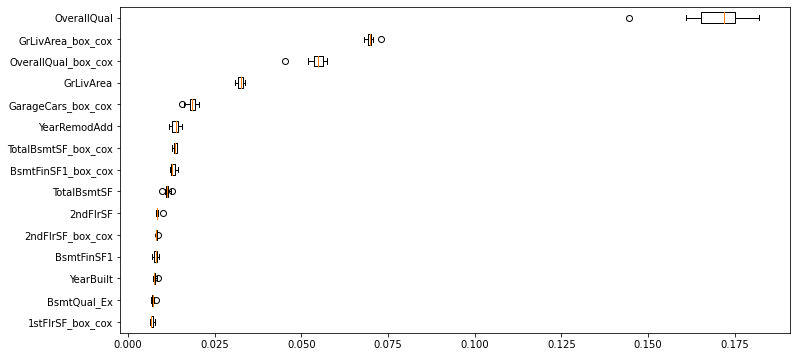

In [10]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.boxplot(result.importances[sorted_idx[-15:]].T,
            vert=False, labels=np.array(data.columns)[sorted_idx[-15:]])
fig.show()

In [11]:
# import a tool for getting all possible n over 2 combinations of these variables
from itertools import combinations
# and add the interactions
interactions = []
for comb in list(combinations(data.columns[sorted_idx[-15:]], 2)):
    data[comb[0] + '_x_' + comb[1]] = data[comb[0]] * data[comb[1]]
    interactions.append(comb[0] + '_x_' + comb[1])

data_interactions = data[interactions]


## 1.
# now, we have different data sets
# the base set with missing values imputed by the mean and no other feature engineering
# box-cox transformed variables are removen
base = data_base[[col for col in data_base.columns if not col.endswith('_box_cox')]]
## 2.
# box_cox is admitted; original variables removed
with_box_cox = data_base[[col for col in data_base.columns if not col in box_cox]]
## 3.
# variables indicating formerly missing values are included
with_na = pd.concat([with_box_cox, data_na], axis = 1)
## 4.
# all interaction terms of the 55 most important variables are added
with_interactions = pd.concat([with_na, data_interactions], axis = 1)

## the target variable is log-transformed
y = np.log1p(SalePrice)

## since we want to try elasticnet, we have to find the optimal parameter for 
# lambda (amount of regularization) and for alpha (ratio of lasso and ridge mixing)
lamb = 10**(np.linspace(-1, 0.2, 15))
# ratio
ratio = np.linspace(0, 1, 10)

In [12]:
error = []
best_parameters = []
# we iterate over list of data-sets
for d in [base, with_box_cox, with_na, with_interactions]:
    # scale variables
    scaler = StandardScaler()
    scaler.fit(d[:len(train_ID)]) #  fit  the scale        

    X_train = scaler.transform(d[:len(train_ID)])
    X_test = scaler.transform(d[len(train_ID):])
    
    # the function cross_val_score computes the model passed to it for cv=5-fold 
    # cross validation; we compute the mean over the 5 folds
    get_results = [(l, r, np.mean(np.sqrt(-cross_val_score(ElasticNet(alpha = l,
                                                            l1_ratio = r),
            X_train, y , scoring = 'neg_mean_squared_error',
            cv = 5, n_jobs = -1))))
                for l in lamb for r in ratio]
    
    # the least error is extracted
    least_error = np.min([i[2] for i in get_results])
    error.append(least_error)
    # the parameters belonging to the best result
    parameters = [i[0:2] for i in get_results if i[2] == least_error]
    best_parameters.append(parameters)
    print(f'least error is: {least_error}, best parameters are: {parameters}')


least error is: 0.1382281067080659, best parameters are: [(0.3981071705534972, 0.0)]
least error is: 0.13065758654150422, best parameters are: [(0.1, 0.1111111111111111)]
least error is: 0.13065758650403755, best parameters are: [(0.1, 0.1111111111111111)]
least error is: 0.12848085957553873, best parameters are: [(0.22022019499873752, 0.0)]


In [13]:
best_parameters

[[(0.3981071705534972, 0.0)],
 [(0.1, 0.1111111111111111)],
 [(0.1, 0.1111111111111111)],
 [(0.22022019499873752, 0.0)]]

In [14]:
display(base.shape, with_box_cox.shape, with_na.shape, with_interactions.shape)

(2919, 310)

(2919, 310)

(2919, 346)

(2919, 451)

We conclude:
1. The error for the base data set (only missing values imputed) is: {{np.round(error[0], 4)}}  (mse); The corresponding lambda is {{np.round(best_parameters[0][0][0], 4)}}, i.e. the amount of regularization; the l1_ratio = {{np.round(best_parameters[0][0][1], 4)}}; the kind of regularization was pure ridge (l2-penalty)
2. The error with some of the numeric variables box-cox transformed is {{np.round(error[1], 4)}} (mse); the amount of regularization is far less than before ({{np.round(best_parameters[1][0][0], 4)}}); we have {{np.round(best_parameters[1][0][1] * 100)}}% l1-penalty and {{np.round(100 - (best_parameters[1][0][1] * 100))}}% l2-penalty
3. Indicator variables for formerly missing values are included in the data-set; The error ({{np.round(error[2], 4)}}) shrinks by an insignificant amount. The lambda parameter is {{np.round(best_parameters[2][0][0], 4)}}; no l1-penalty is used
4. adding the interaction terms has the most pronounced effect. The error drops to {{np.round(error[3], 4)}}; The best parameters are as before.

One additional note: By including the interaction terms, we have __more variables (1831) than observations (1460)__ in the training set. This situation is not admissable in classical statistics. For machine learning algorithms with regularization, it does not mean any problem.

We now have found the best parameters by cross-validation. Now, we try to solve a business problem with these results:<br>
__The sales team needs all houses from the test set with estimated prices higher than 350'000\$. Can you please deliver an estimate about how accurate your predictions are?__<br>
1. Compute the confidence intervals for the test-set.
We proceed as follows:
2. Obtain estimates for the train-set by splitting the train-set in k=5 folds and always train on 4 folds and make predictions on the 5th fold. We obtain CIs in this manner.
3. We take the lower-bounds of the confidence intervals. This ensures, that we do not include cases (houses) with very unstable estimates.
4. Since we trained the CIs for the training-set with cross-validation, we can treat them as an estimate for the accuracy of the CIs of the test-set: This gives us an estimate of the error we make.

In [15]:
import warnings
from random import choices
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold # import KFold
warnings.filterwarnings('ignore')
# we get a lot of warnings:
# LinAlgWarning: Ill-conditioned matrix (rcond=1.80167e-08): result may not be accurate.
#  overwrite_a=False)
# this is because we use more variables than observations and we get the already discussed
# problems with matrix inversion


scaler = StandardScaler()
scaler.fit(with_interactions) #  fit  the scale        


X = scaler.transform(with_interactions[:len(train_ID)])
test = scaler.transform(with_interactions[len(train_ID):])

## 1.
indices = np.arange(0, X.shape[0])
# draw 200 samples with replacement from training data set
sampler = (choices(indices, k = len(indices)) for i in range(200))
# fit 200 models to the samples drawn and predict on test-set
# 
CIS_test = np.percentile(
            np.array(
                [
                 Ridge(alpha=best_parameters[-1][0][0], fit_intercept=True)\
                 .fit(X[drew,:], y.values[drew]).predict(test).tolist()
                 for drew in sampler]
                 ), [2.5, 97.5], axis = 0)


## 2.
kf = KFold(n_splits = 5, shuffle=True)
CIS = np.empty((2, X.shape[0]))
y_hat = np.empty((y.shape[0],))
for train_index, test_index in kf.split(X):
    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index, :]
    y_test = y[test_index]
    indices = np.arange(0, X_train.shape[0])

    sampler = (choices(indices, k = len(indices)) for i in range(200))
    CIS[:, test_index] = np.percentile(
        np.array(
            [
             Ridge(alpha=best_parameters[-1][0][0], fit_intercept=True)\
             .fit(X_train[drew,:], y_train.values[drew])\
                              .predict(X_test).tolist()
             for drew in sampler]
             ), [2.5, 97.5], axis = 0)


In [16]:
## 3.
bool_indizes = np.exp(CIS_test[0, :]) - 1 > 350000
sum(bool_indizes)
for_sales_departement = list(
    zip(np.arange(0, CIS_test.shape[1])[bool_indizes], np.exp(CIS_test[0, bool_indizes])+1)
)


In [17]:
y_hat_lower = np.exp(CIS[0,:])-1
estimates = y_hat_lower > 350000
true = (np.exp(y) +1) > 350000
y_hat_lower[estimates]
print(f'we estimate that {np.round(np.mean(true[estimates]) * 100, 2)}% of our predictions are correct')
print(f'\nhowever, we only got {np.round(sum(estimates)/sum(true)*100, 2)}% of all houses with prices higher than 350000')


we estimate that 90.0% of our predictions are correct

however, we only got 35.71% of all houses with prices higher than 350000


## Now, suppose
the sales team wants to use your algorith for new incoming houses. How good can we predict theses houses?

__Exercise:__ get the estimates right by help of python Pipelines

In [18]:
!pwd

/home/martin/python/fhnw_lecture/notebooks


In [2]:
import pandas as pd

One-hot encoding and adding variables for missing values is not critical: no statistics are fitted<br>

we load the data (only train) once again:

In [2]:
train = pd.read_csv('../data/train.csv', sep=",")
train_ID = train['Id']
train.drop('Id', axis = 1, inplace = True)
SalePrice = train['SalePrice']
train.drop('SalePrice', axis=1, inplace = True)
categorical = [var for var in train.columns if train[var].dtype=='O']
numerical = [var for var in train.columns if train[var].dtype!='O']

Next we add an indicator variable for every missing value: no statistics are fitted:

In [3]:
train[categorical] = train[categorical].fillna('None')
for val in numerical:
    train[val + '_na'] = pd.isnull(train[val])

what however depends on the data - statistcs are fitted is:<br>
- filling NAs with mean-values
- box-cox transform of variable
- computing the best features and forming interaction variables
- fitting the model

In [4]:
import sys
import os
import numpy as np
sys.path.append(os.path.abspath('../scripts'))
from interactions_transformer import InteractionsTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

numeric_features = numerical
categorical_features = categorical

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', PowerTransformer(method='box-cox'))])

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical),
        ])

clf = GridSearchCV(
        make_pipeline(
            preprocessor,
            InteractionsTransformer(),
            ElasticNet()
            ),
            param_grid={'elasticnet__alpha': 10**(np.linspace(-1, 0.2, 5)),
                        'elasticnet__l1_ratio': np.linspace(0, 1, 6)},
         cv=5, refit=False, scoring = 'neg_mean_squared_error'
)


starting feature importance


In [6]:
train[numerical] += 1
clf.fit(train, np.log1p(SalePrice))

starting feature importance
starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.777683070147603, tolerance: 0.018912592760396085
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.988919198161462, tolerance: 0.018002191385488822
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.320849864618243, tolerance: 0.018373605848561594
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.004705997123523, tolerance: 0.01900808140370263
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.550876513609879, tolerance: 0.018810611883705176
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance
starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.723625241051913, tolerance: 0.018912592760396085
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.787717750001073, tolerance: 0.018002191385488822
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.868875098433433, tolerance: 0.018373605848561594
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.780044251427249, tolerance: 0.01900808140370263
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.274159672197024, tolerance: 0.018810611883705176
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance
starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.541960218063288, tolerance: 0.018912592760396085
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(varianc

starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.36621659862422, tolerance: 0.018002191385488822
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.127911398321842, tolerance: 0.018373605848561594
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.360373198459275, tolerance: 0.01900808140370263
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.397675654217725, tolerance: 0.018810611883705176
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance
starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.643560556054723, tolerance: 0.018912592760396085
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.43032235559374, tolerance: 0.018002191385488822
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.393552102398456, tolerance: 0.018373605848561594
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.269922111897714, tolerance: 0.01900808140370263
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.99210653697933, tolerance: 0.018810611883705176
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.859840068467427, tolerance: 0.018912592760396085
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(varianc

starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.514595486460657, tolerance: 0.018002191385488822
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.583783463992734, tolerance: 0.018373605848561594
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.11564175651319, tolerance: 0.01900808140370263
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.932519030825013, tolerance: 0.018810611883705176
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance
starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          PowerTransformer(method='box-cox'))]),
                                                                         ['MSSubClass',
                                                                          'LotFrontage',
                                                                          'LotArea',
                                                                          'OverallQual',
                                                   

In [7]:
display(clf.best_params_, np.sqrt(-clf.best_score_))
# clf.cv_results_.keys()

{'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.0}

0.12430292446686393

In [14]:
clf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_elasticnet__alpha', 'param_elasticnet__l1_ratio', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [17]:
np.sqrt(-clf.cv_results_['mean_test_score'])

array([0.12496283, 0.1478108 , 0.16451054, 0.18259267, 0.19989554,
       0.21531103, 0.12714891, 0.16676011, 0.20172811, 0.23436729,
       0.26756237, 0.29948758, 0.13231888, 0.20677164, 0.27599899,
       0.33907628, 0.39448697, 0.39954338, 0.14317419, 0.28659145,
       0.39542575, 0.39954338, 0.39954338, 0.39954338, 0.15506253,
       0.39658858, 0.39954338, 0.39954338, 0.39954338, 0.39954338])

Now, we have to get the confidence intervalas CIs

In [15]:
from sklearn.model_selection import KFold # import KFold
from random import choices
train[numerical] += 1

kf = KFold(n_splits = 5, shuffle=True)
CIS = np.empty((2, train.shape[0]))
y_hat = np.empty((SalePrice.shape[0],))
for train_index, test_index in kf.split(train):
    X_train = train.iloc[train_index,:]
    y_train = np.log1p(SalePrice)[train_index]
    X_test = train.iloc[test_index, :]
    y_test = np.log1p(SalePrice)[test_index]
    indices = np.arange(0, X_train.shape[0])

    custom_pipeline = make_pipeline(
            preprocessor,
            InteractionsTransformer(),
            ElasticNet().set_params(alpha=clf.best_params_['elasticnet__alpha'],
                                   l1_ratio=clf.best_params_['elasticnet__l1_ratio']))
    sampler = (choices(indices, k = len(indices)) for i in range(200))
    runs = []
    for drew in sampler:
        try:
            runs.append(custom_pipeline.\
             fit(X_train.iloc[drew, :], y_train.iloc[drew]).predict(X_test).tolist()
                       )
        except:
            pass
            
    CIS[:, test_index] = np.percentile(np.array(runs), [2.5, 97.5], axis = 0)

starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.613205454618703, tolerance: 0.018892127220815114
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance

/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.642874802190793, tolerance: 0.01848043797617459
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might 

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.069296804707072, tolerance: 0.018941717197258245
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.237057734948381, tolerance: 0.017262054071920115
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: Ru

/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.372510068962175, tolerance: 0.01853483419349869
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might 

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.466005190831023, tolerance: 0.019759331240135833
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number 

/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.921042958250505, tolerance: 0.01835512375366601
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might 

/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.007729385753274, tolerance: 0.017524204887105245
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.044744565227136, tolerance: 0.01944467796460011
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: Run

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.460804231404234, tolerance: 0.01730164163366596
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.948126445774788, tolerance: 0.017749516809145476
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: R

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.008155760668885, tolerance: 0.01852488437495642
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.470665584398368, tolerance: 0.01864949836680934
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered i

/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.54230320782837, tolerance: 0.01739289160843334
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might w

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.733428618481362, tolerance: 0.01925678583727352
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.330510299583807, tolerance: 0.017994205794960107
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: Run

/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.191198892074462, tolerance: 0.01704443703950116
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np

/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.305795832686904, tolerance: 0.01990196071701592
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/home/martin/m

/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.069234885248045, tolerance: 0.01855888578107503
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might 

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.090579561588097, tolerance: 0.02032166861796957
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number o

/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.422082984149477, tolerance: 0.017915757021473244
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/home/martin/

starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.4040568635976, tolerance: 0.01924745173761578
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.155784661498577, tolerance: 0.019461530192280387
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might

/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.6755993690962, tolerance: 0.019541091010294814
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might w

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.876884823270964, tolerance: 0.019815046841536448
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number 

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.703618771160989, tolerance: 0.018533869423588763
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.273813452727168, tolerance: 0.01926372959359913
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: Run

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.927325534275414, tolerance: 0.01832662853345617
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.177501405839598, tolerance: 0.02051504826637332
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: Runt

/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.535305696641769, tolerance: 0.0184018365166877
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might w

/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.677068159402458, tolerance: 0.01876077422643428
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might 

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.63099133964722, tolerance: 0.02057141605656082
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.310606731173903, tolerance: 0.01806067280753565
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: Runti

/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.128710038351821, tolerance: 0.018168154860779873
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:192: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.217042058797187, tolerance: 0.018205736851091725
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number 

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.097700402125835, tolerance: 0.017960442183301933
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.2982480702707475, tolerance: 0.017806973382921972
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906:

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.14520746268914, tolerance: 0.01884089478676708
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.314811567283636, tolerance: 0.019104773132536966
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: Runt

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.72310976065133, tolerance: 0.019143989360890526
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.022721186856328, tolerance: 0.02002066188870863
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: Runt

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.181925701958352, tolerance: 0.018215503700126017
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.111650656188415, tolerance: 0.018762210336356923
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: Ru

/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.826023464150317, tolerance: 0.019229226482936013
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.72106272179193, tolerance: 0.01864837427207594
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of

starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.992663589526674, tolerance: 0.018236531892614115
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.813980182008031, tolerance: 0.01902308539276269
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.31820202793062, tolerance: 0.01890348607430469
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: Runti

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.653317445828169, tolerance: 0.0183666975329148
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.009704838562097, tolerance: 0.017815493584182197
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: Runt

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.792741741916896, tolerance: 0.017257628528575576
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:192: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the 

/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.8867275973360425, tolerance: 0.01797689229017332
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might

/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.585717245893238, tolerance: 0.019206818811137817
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * n

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.40523698342346, tolerance: 0.016611783056157098
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.131623430949004, tolerance: 0.018621528450804288
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: Run

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.49132573275554, tolerance: 0.018327863634478598
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/m

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.281846652581448, tolerance: 0.0157431001282777
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.009657702615623, tolerance: 0.018558567720247856
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: Runt

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.070941952022343, tolerance: 0.018478180590830125
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.344651944972869, tolerance: 0.017697006180778994
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: Ru

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.328460655121201, tolerance: 0.01837309852853617
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number o

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.965173578439954, tolerance: 0.018692222953387322
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number 

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.814192148193827, tolerance: 0.018516398356826506
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.216826046050091, tolerance: 0.01749500960942936
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: Run

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.8945668550938555, tolerance: 0.01802418614126833
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number 

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.213073932709943, tolerance: 0.019663960445701664
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.8357532231931, tolerance: 0.016508209154579154
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encounte

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.34838135628869, tolerance: 0.019154045481805503
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/m

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.95538950505035, tolerance: 0.017379095466089456
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.8652052842394555, tolerance: 0.01816905779888351
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: Run

starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.21979376196856, tolerance: 0.019481681843918363
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might 

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.766564899829294, tolerance: 0.02001655210515407
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number o

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.821692848777209, tolerance: 0.01876403801480943
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number o

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.565961428989798, tolerance: 0.018786716630935747
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.178981833577092, tolerance: 0.02071844575885067
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number o

/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.975710271798132, tolerance: 0.019112554869327836
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.5886480918185715, tolerance: 0.017838467670554182
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.413142160165305, tolerance: 0.017451982582958853
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: R

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.329289077644539, tolerance: 0.019657052752323854
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number 

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.390907511402357, tolerance: 0.017890280280336318
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.641131987683824, tolerance: 0.019671645679701442
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: Ru

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.179373490290991, tolerance: 0.02022111919043104
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number o

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.927390564297845, tolerance: 0.018884116807496406
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number 

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.6572715491425605, tolerance: 0.019144102657187904
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.803560985610551, tolerance: 0.0186826297947693
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.982230675057234, tolerance: 0.018903092027414786
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encounte

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.812396684427153, tolerance: 0.02052057734188461
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number o

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.823469046424524, tolerance: 0.017954254042089206
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.758433310862651, tolerance: 0.019924672699390664
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encoun

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.770497809521073, tolerance: 0.018528428302569917
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.628606807111803, tolerance: 0.020965865250963236
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.059774949731366, tolerance: 0.020845602180099558
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: Ru

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.82270159069755, tolerance: 0.017655283150662286
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.46514442586627, tolerance: 0.018704290808883948
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: Runt

starting feature importance


/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.5403135462545725, tolerance: 0.01919275387288426
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.569683387305696, tolerance: 0.017629342302828817
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.475922242040722, tolerance: 0.018857144101343242
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: Ru

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.320372224774129, tolerance: 0.018301215875568454
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.506567053299542, tolerance: 0.01735394869082518
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: Run

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.607363521129542, tolerance: 0.01730002736470776
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.377711140763418, tolerance: 0.01852199211044962
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: Runt

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.930295454649736, tolerance: 0.01919868367546655
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.816864227854159, tolerance: 0.01814046260580115
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: Runt

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.380733163608551, tolerance: 0.01788874123923708
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number 

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.4108785246138105, tolerance: 0.019134428779765525
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.656490479260913, tolerance: 0.01804693493830432
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number o

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.977944630642337, tolerance: 0.01726682089316692
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number o

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.938543153302886, tolerance: 0.01811080075670179
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/m

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.5497667374894215, tolerance: 0.019015503152155017
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.7359420467012106, tolerance: 0.02016676908555856
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906:

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.940295096280082, tolerance: 0.018645721126295537
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.836727741044211, tolerance: 0.017709329397444552
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: Ru

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.46097336405674, tolerance: 0.019329585764716554
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.533504951166231, tolerance: 0.019007413839288577
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: R

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.667580828657244, tolerance: 0.019040048433036097
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.8101734995892205, tolerance: 0.01873341266507044
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: 

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.329142763931438, tolerance: 0.01798161438760313
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.01991331967967, tolerance: 0.01920177708437304
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:906: Run

/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.605532923193655, tolerance: 0.019008635207000153
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.610133205184002, tolerance: 0.01885734742941973
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: Run

/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.31311465372772, tolerance: 0.019282060469773977
  positive)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np

In [21]:
y_hat_lower = np.exp(CIS[0,:]) - 1
estimates = y_hat_lower > 350000
true = SalePrice > 350000
y_hat_lower[estimates]
print(f'we estimate that {np.round(np.mean(true[estimates]) * 100, 2)}% of our predictions are correct')
print(f'\nhowever, we only got {np.round(sum(estimates)/sum(true)*100, 2)}% of all houses with prices higher than 350000')


we estimate that 90.91% of our predictions are correct

however, we only got 40.74% of all houses with prices higher than 350000


### we add mean-encoder aka target-encoder 

In [23]:
!pip install category_encoders

     |████████████████████████████████| 80 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 4.6 MB/s eta 0:00:01     |██▏                             | 645 kB 2.2 MB/s eta 0:00:04
     |████████████████████████████████| 231 kB 3.6 MB/s eta 0:00:01


In [24]:
from validatedstackedmeanencoder import ValidatedStackedMeanEncoder

In [25]:
numeric_features = numerical
categorical_features = categorical

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', PowerTransformer(method='box-cox'))])

#categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)
categorical_transformer = ValidatedStackedMeanEncoder(cols = categorical)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical),
        ])


custom_pipeline = make_pipeline(
            preprocessor,
            InteractionsTransformer(),
            ElasticNet().set_params(alpha=clf.best_params_['elasticnet__alpha'],
                                   l1_ratio=clf.best_params_['elasticnet__l1_ratio'])
            )

starting feature importance


In [29]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5)
y = np.log1p(SalePrice)
sores = []
for train_idx, val_idx in cv.split(train, y):
    custom_pipeline.fit(train.iloc[train_idx], y.iloc[train_idx])
    prediction = custom_pipeline.predict(train.iloc[val_idx])
    scores.append(np.mean(np.sqrt(mean_squared_error(y.iloc[val_idx], prediction))))

print(scores)

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.